# Lab 1: ConceptNet Ethics Testing

#### Henry Lambson, Alex Gregory, Mike Wisniewski

TODOs:
    - Choose a second methodology at assessing bias
        -Ideas: Instead of SGD for sentiment analysis we can use a LSTM
        -Change the dataset to another dataset

### Part 1: Overview of Bias

>Present an overview for what type of bias you will be investigating and why the particular investigation you will be doing is relevant. You might consider asking questions like: Why is it important to find this kind of bias in machine learning models? Why will the type of investigation I am performing be relevant to other researchers or practitioners? 


For our analysis of ConceptNet, our group decided to look into the potential bias the modal has to gender. We want to find out if there is a systematic difference between words associated with males and words associated with females. An example of this being "waiter" vs "waitress". We believe that this investigation is relevant because we think that future models trained on the large, unfiltered GloVe data will be inherently biased towards male positions.  We compare this to ConceptNet Numberbatch embeddings for further analysis into inherent biases that exist in language data.  We believe that these datasets will be biased towards male terms from a sentiment point of view where male words are perceived as positive while female words are perceived as negative.  We want to use job titles and other stereotypically gendered words as a way to expose this bias. 

If these datasets are distriminatory when it is not meant to be, it can affect the businesses, consumers, researchers, and practioners using these datasets.  From the business perspective, businesses risk their bottom line and credibility. From a consumer perspective, consumers are at risk of being alienated due to their identity.  From the researcher and practioner point of view, these biases can skew potential researches using these datasets - effectively calling into question the credibility of these researches as well as researchers.  Due to this bias, we believe that low level NLP models can be biased in a way that will hurt businesses trying to reach consumers equally.

### Part 2: Research Questions

>Present one or more research questions that you will be answering and explain the methods that you will employ to answer these research questions. Present a hypothesis as part of your research questions. 

Our main research question: Are inherent gender biases in GloVe mitigated to a "better" degree than ConceptNet Numberbatch in the application domain of sentiment analysis?

### Part 3: Methodology
>As part of your assignment, you will choose a methodology that involves comparing two (or more) techniques to one another. Discuss how you will measure a difference between the two techniques. That is, if you are measuring the difference statistically, what test will you use and why is it appropriate? Are there any limitations to performing this test that you should be aware of?

We will be choosing to compare GloVe vs ConceptNet Numberbatch in which, according to our hypothesis, we will be measuring gender bias in both datasets, with the assumption that GloVe has less bias than Numberbatch.  In order to test this methodology, we will use a T-test, AUC for supporting evidence, and McNemar Test.

### Set up Environment with import and helper functions

This first large section of code is grabbed from the in class example. We are using the same pre-processing that was shown and used in class. Once we have a sentiment analyzer, we will begin testing it for different biases. 

In [22]:
# import relevant packages
import numpy as np
import pandas as pd
import matplotlib
import seaborn
import re
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from matplotlib import pyplot as plt

# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [2]:
# load embeddings from a given file name
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [3]:
# load lexicons from a given file name
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [4]:
def create_vectors_targets_labels(pos_words, neg_words, embeddings):
    """
    Pass through a list of positive and negative words as well
    as an embedding from word2vec, GloVe, fastText, or 
    ConceptNet Numberbatch

    return a list of vectors and associated targets and labels per embedding
    """

    # parse out the positive words that appear in our embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index))

    # parse out the negative words that appear in our embeddings
    neg_words_common = list(set(neg_words) & set(embeddings.index)) 

    # vectorize positive and negative common words
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]

    # create pd dataframe of positive and negative vectors
    vectors = pd.concat([pos_vectors, neg_vectors])

    # create a numerical representation of positive and negative vectors
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    return vectors, targets, labels

In [5]:
def create_model(vectors, targets, labels):
    """
    For a set of vectors, targets, and labels, create an SGD model
    and fit the model on training sets
    
    return model, model_accuracy, test_vectors, test_targets, test_labels
    """

    # split the dataset
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

    # initialize log loss classifier
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)

    # fit model
    model.fit(train_vectors, train_targets)

    # score model on test data
    print(accuracy_score(model.predict(test_vectors), test_targets))
    model_accuracy = accuracy_score(model.predict(test_vectors), test_targets)

    return model, model_accuracy, test_vectors, test_targets, test_labels

In [6]:
def vecs_to_sentiment(vecs, model):
    """
    To see an overall positive vs. negative classification in one number,
    we take the log probability of positive sentiment minus the log
    probability of negative sentiment.
    this is a logarithm of the max margin for the classifier, 
    similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    """

    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words, embeddings, model):
    # vectorize the word
    vecs = embeddings.loc[words].dropna()

    # calculate log probability
    log_odds = vecs_to_sentiment(vecs, model)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)

In [7]:
# sentiment for multiple words
def text_to_sentiment(text, embeddings, model):

    TOKEN_RE = re.compile(r"\w.*?\b")
    # The regex above finds tokens that start with a word-like character (\w), and continues
    # matching characters (.+?) until the next word break (\b). It's a relatively simple
    # expression that manages to extract something very much like words from text.

    # tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]

    # send each token separately into the embedding, then the classifier
    sentiments = words_to_sentiment(tokens, embeddings, model)

    # return the mean for the classifier
    return sentiments['sentiment'].mean() 

In [8]:
# create a table of sentiment values for each word
def term_sentiment_table(terms, embeddings, model):

    # initialize empty frame
    frames = []

    # for gender and term
    for gender, term_list in sorted(terms.items()):
        for term in term_list:

            # calculate sentiment
            sentiments = text_to_sentiment(term, embeddings, model)

            # append to dataframe
            frames.append([sentiments,term,gender])

    # Put together the data we got from each ethnic group into one big table
    return frames

In [9]:
def mcnemar_test(acc1, acc2):
    t = 2.26 / np.sqrt(10)  # 2.26 is looked up in a book for 95% CI
    e1 = 1-acc1
    e2 = 1-acc1
    e = e1 - e2
    stdtot = np.std(e)
    dbar = np.mean([e1, e2])

    print(dbar - t * stdtot, dbar + t * stdtot)
    return dbar - t * stdtot, dbar + t * stdtot

In [18]:
def roc_calc(model, X_test, y_test):
    yhat = model.predict(X_test)
    false_positive, true_positive, _ = mt.roc_curve(y_test.flatten(), yhat.flatten())
    roc = mt.auc(false_positive, true_positive)
    return false_positive, true_positive, roc

### Part 4: Analysis
> Carryout your analysis and model training. Explain your steps in as much detail so that the instructor can understand your code. 



From here, we will be testing out multiple datasets to try to find a bias due to gender. ConceptNet has a list of pairings that are typically associated with males and females. We decided to use this list as one of our datasets to test on. The female terms are on the left, and the male terms are on the right.

In [11]:
GENDER_BIAS_PAIRS = [
    ('pediatrician', 'orthopedic surgeon'),
    ('housewife', 'shopkeeper'),
    ('skirts', 'shorts'),
    ('interior designer', 'architect'),
    ('feminism', 'conservatism'),
    ('adorable', 'goofy'),
    ('vocalists', 'guitarists'),
    ('cosmetics', 'pharmaceuticals'),
    ('whore', 'coward'),
    ('vocalist', 'guitarist'),
    ('petite', 'lanky'),
    ('blond', 'burly'),
    ('nanny', 'chauffeur'),
    ('sassy', 'snappy'),
    ('charming', 'affable'),
    ('giggle', 'chuckle'),
    ('witch', 'demon'),
    ('volleyball', 'football'),
    ('feisty', 'mild mannered'),
    ('cupcakes', 'pizzas'),
    ('dolls', 'replicas'),
    ('netball', 'rugby'),
    ('glamorous', 'flashy'),
    ('sweater', 'jersey'),
    ('feminist', 'liberal'),
    ('rebounder', 'playmaker'),
    ('nude', 'shirtless'),
    ('judgmental', 'arrogant'),
    ('lovely', 'brilliant'),
    ('practicality', 'durability'),
    ('singer', 'frontman'),
    ('violinist', 'virtuoso'),
    ('beautiful', 'majestic'),
    ('sexism', 'racism'),
    ('pink', 'red'),
    ('hysterical', 'comical'),
    ('beauty', 'grandeur'),
    ('cheerful', 'jovial')
]

FEMALE_ARR = [x[0] for x in GENDER_BIAS_PAIRS]
MALE_ARR = [x[1] for x in GENDER_BIAS_PAIRS]
TERM_DICT = {"Female":FEMALE_ARR, "Male":MALE_ARR}

In [12]:
%%time

# load glove embeddings
glove_embeddings = load_embeddings('glove.840B.300d/glove.840B.300d.txt')

# load ConceptNet embeddings
cnnb_embeddings = load_embeddings('numberbatch-en/numberbatch-en.txt')

# import positive and negative words
pos_words = load_lexicon('opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('opinion-lexicon-English/negative-words.txt')

Wall time: 3min 15s


In [13]:
# create vectors, targets and labels for each embedding
glove_vectors, glove_targets, glove_labels = create_vectors_targets_labels(pos_words, neg_words, glove_embeddings)
cnnb_vectors, cnnb_targets, cnnb_labels = create_vectors_targets_labels(pos_words, neg_words, cnnb_embeddings)

# initialize models
glove_model, glove_model_accuracy, glove_test_vectors, glove_test_targets, glove_test_labels = create_model(glove_vectors, glove_targets, glove_labels)
cnnb_model, cnnb_model_accuracy, cnnb_test_vectors, cnnb_test_targets, cnnb_test_labels = create_model(cnnb_vectors, cnnb_targets, cnnb_labels)

# create a dataframe of sentiment values
glove_term_sentiments = term_sentiment_table(TERM_DICT, glove_embeddings, glove_model)
cnnb_term_sentiments = term_sentiment_table(TERM_DICT, cnnb_embeddings, cnnb_model)
glove_term_df = pd.DataFrame(glove_term_sentiments, columns = ["Sentiment","Term","Gender"])
cnnb_term_df = pd.DataFrame(cnnb_term_sentiments, columns = ["Sentiment","Term","Gender"])

0.9410876132930514
0.9841772151898734


>Present results from your analysis and provide evidence from the results that support or refute your hypothesis. Write a conclusion based upon the various analyses you performed. Be sure to reference your research questions systematically in your conclusion. With your analysis complete, are there any additional research questions or limitations to your conclusions?

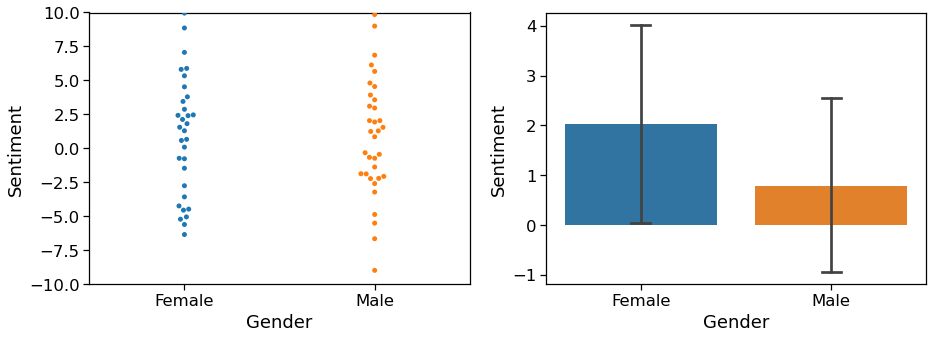

In [14]:
# analysis 1: GloVe
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='Gender', y='Sentiment', data=glove_term_df)
plot.set_ylim([-10, 10]) 
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='Gender', y='Sentiment', data=glove_term_df, capsize=.1)

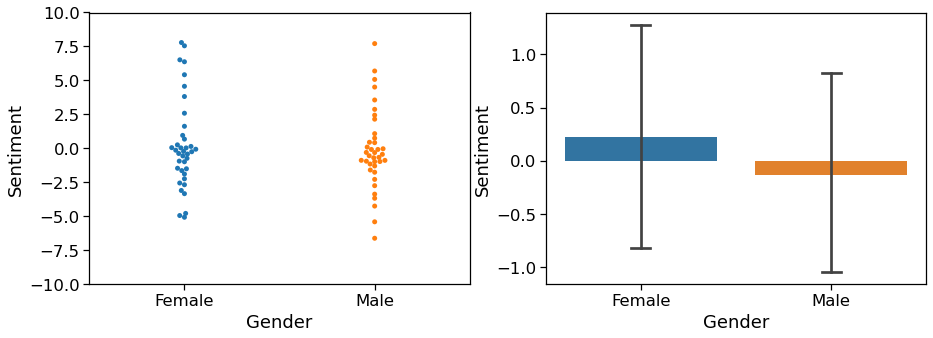

In [15]:
# analysis 2: ConceptNet Numberbatch
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='Gender', y='Sentiment', data=cnnb_term_df)
plot.set_ylim([-10, 10]) 
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='Gender', y='Sentiment', data=cnnb_term_df, capsize=.1)

In [20]:
# get the average AUC for all models
glove_fp, glove_tp, glove_roc = roc_calc(glove_model, glove_test_vectors, glove_test_targets)
cnnb_fp, cnnb_tp, cnnb_roc = roc_calc(cnnb_model, cnnb_test_vectors, cnnb_test_targets)

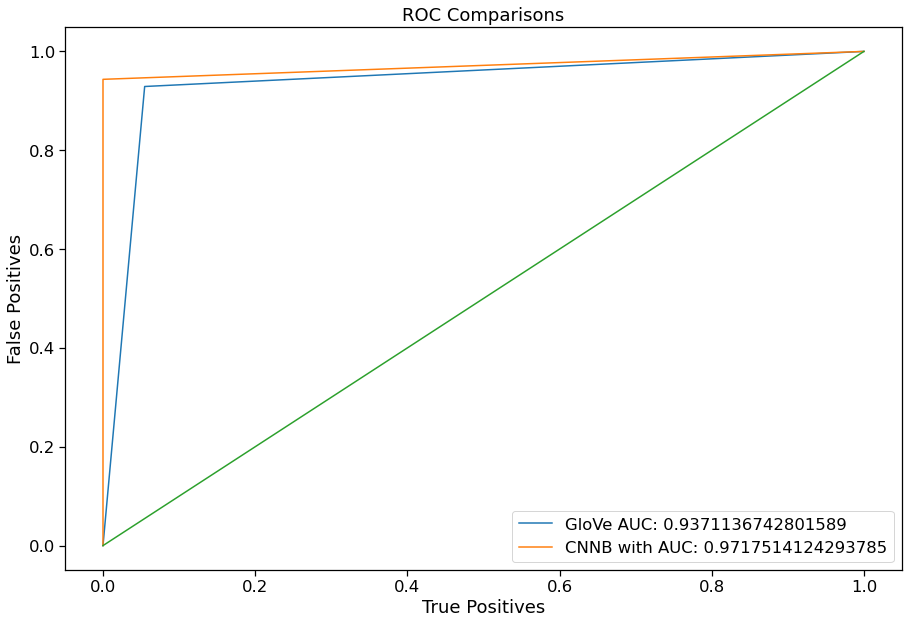

In [23]:
# plot out all model AUC
plt.figure(figsize=(15,10))
plt.title('ROC Comparisons')
plt.plot(glove_fp, glove_tp)
plt.plot(cnnb_fp, cnnb_tp)
plt.plot([0, 1])
plt.ylabel('False Positives')
plt.xlabel('True Positives')
plt.legend([f"GloVe AUC: {glove_roc}", f"CNNB with AUC: {cnnb_roc}"])

In [25]:
mcnemar_test(glove_model_accuracy, cnnb_model_accuracy)

0.05891238670694865 0.05891238670694865


(0.05891238670694865, 0.05891238670694865)

>Identify two conferences or journals that would be interested in the results of your analysis.  

### References
[1] https://careersmart.org.uk/occupations/equality/which-jobs-do-men-and-women-do-occupational-breakdown-gender